## Imports

In [3]:
import time
import pandas as pd
from scipy.io import mmread # for reading the mtx.gz files
import numpy as np
from sklearn.neighbors import NearestNeighbors # read notes at `estimate_sigma`
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform

## Set up time

In [4]:
start = time.time()

## Generating DataFrames

In [5]:
def load_data(counts_matrix_path, features_path, barcodes_path):
    '''Loads the gene expression counts matrix and associated feature and barcode files. Uses dense matrices for easier processing.

    Parameters:
        counts_matrix_path (str): path to the gene expression counts matrix file in MTX format.
        features_path (str): path to the features file that has the gene identifiers/names.
        barcodes_path (str): path to the barcodes file that has the cell identifiers.

    Returns: A tuple with the following three things:
        matrix (pd.DataFrame): Dense matrix of gene expression counts with shape (genes, cells).
        features (pd.DataFrame): DataFrame with the gene IDs and names.
        barcodes (pd.DataFrame): DataFrame with the cell barcodes.
    '''
    matrix = mmread(counts_matrix_path).todense()  # converting to dense for easier processing
    features = pd.read_csv(features_path, sep='\t', header=None)
    barcodes = pd.read_csv(barcodes_path, sep='\t', header=None)
        
    return matrix, features, barcodes

In [6]:
# Data read-ins
fem_counts_matrix_path = 'data/GSM8441017_female_AVS_HH6_matrix.mtx.gz'
fem_features_path = 'data/GSM8441017_female_AVS_HH6_features.tsv.gz'
fem_barcodes_path = 'data/GSM8441017_female_AVS_HH6_barcodes.tsv.gz'
male_counts_matrix_path = 'data/GSM8441018_male_AVS_HH4_matrix.mtx.gz'
male_features_path = 'data/GSM8441018_male_AVS_HH4_features.tsv.gz'
male_barcodes_path = 'data/GSM8441018_male_AVS_HH4_barcodes.tsv.gz'

# Female
fem_counts_matrix, fem_features, fem_barcodes = load_data(fem_counts_matrix_path, fem_features_path, fem_barcodes_path)

# Male
male_counts_matrix, male_features, male_barcodes = load_data(male_counts_matrix_path, male_features_path, male_barcodes_path)

In [91]:
fem_df = pd.DataFrame(fem_counts_matrix.T, index=fem_barcodes[0], columns=fem_features[1]) # Used transpose so that genes are the features.
male_df = pd.DataFrame(male_counts_matrix.T, index=male_barcodes[0], columns=male_features[1])
fem_df.head(5) # Used transpose so that genes are the features.

1,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGACGGATC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCAAGGAGGGTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCAAGGCACGAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACAAACGAGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACAAGGGTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating High-Dimension Similarities (Euclidean distance and Gaussian distribution)

In the `umap-learn` library (most commonly used Python library for UMAP), the default value for `sigma` (basically the "spread" of the Gaussian kernel) is tuned based on the data. It uses the median distance to the k-nearest neighbors (`n_neighbors` parameter is 15 by default) as the estimate for `sigma`. Basically, if points are close to each other, then their similarity is higher, while more distant points have a lower similarity.

My original code was setting `sigma` to the median of the pairwise distances, meaning that I would be looking through every single point rather than just the nearest neighbors. Unfortunately, this might result in outliers influencing the value of sigma, potentially making the kernel scale too large or too small for certain points in denser areas. Because of this, I made a last minute switch to mimic `umap-learn` with sklearn's `NearestNeighbors`.

In [8]:
def estimate_sigma(data, n_neighbors=15): # default is 15 in umap-learn
    # Get distances to n_neighbors nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors.fit(data)
    distances, blah = neighbors.kneighbors(data)
    
    # Get the median distance of the knn
    median_distance = np.median(distances[:, -1])  # using distance to the k-th nearest neighbor
    
    return median_distance


In [9]:
fem_sigma = estimate_sigma(fem_df.values, n_neighbors=15)
male_sigma = estimate_sigma(male_df.values, n_neighbors=15)
print(f"Estimated sigma for female df: {fem_sigma}")
print(f"Estimated sigma for male df: {male_sigma}")

Estimated sigma for female df: 51.749396131742444
Estimated sigma for male df: 76.75610552123781


In [10]:
def get_high_dim_similarity_matrix(data, n_neighbors=15, sigma=None):
    ''' Computes the pairwise Gaussian similarity matrix for the given data using UMAP-like sigma calculation.
    
    Parameters:
        data: the DataFrame of gene expression data
        n_neighbors: number of nearest neighbors (default 15)
        sigma: scaling parameter of Gaussian kernel. If None, it will be estimated automatically similar to umap-learn
    
    Returns:
        similarity_matrix: matrix where the value at [a, b] is the similarity b/w data points a and b.
    '''
    if sigma is None:
        sigma = estimate_sigma(data, n_neighbors) # getting sigma like umap-learn
    
    # Calculating pairwise Euclidean distances for all points
    distances = euclidean_distances(data, data)

    # Convert distances to similarities with gaussian
    similarity_matrix = np.exp(-0.5 * (distances / sigma) ** 2)

    # Going w/ sparse matrices which allow faster computation of operations by focusing only on the non-zero elements.
    similarity_matrix_sparse = csr_matrix(similarity_matrix)

    return similarity_matrix_sparse


In [ ]:
fem_similarity_matrix = get_high_dim_similarity_matrix(fem_df.values, n_neighbors=15)
male_similarity_matrix = get_high_dim_similarity_matrix(fem_df.values, n_neighbors=15)

## Creating the Fuzzy-Simplicial Set
This is basically the pairwise probability distributions. In graph theory terms, it's like a weighted graph where the edges b/w nodes are given probability weights that represent the likelihood that the points belong to the same cluster.

In [ ]:
def get_fuzzy_simplicial(similarity_matrix):
    ''' Creates the fuzzy-simplicial set (pairwise probability distributions) using the similarity matrix.
    
    Parameters:
        similarity_matrix: the high dimension pairwise similarity matrix
    
    Returns:
        fuzzy_simplicial_set: matrix of pairwise probabilities.
    '''
    # Normalizing the similarity matrix
    row_sums = similarity_matrix.sum(axis=1)
    probability_matrix = similarity_matrix / row_sums[:, np.newaxis]

    # The graph needs to be undirected. Need to symmetrize matrix -> P(i,j) = P(j,i)
    probability_matrix = (probability_matrix + probability_matrix.T) / 2
    
    # Use sparse matrix for memory efficiency
    fuzzy_simplicial_set = csr_matrix(probability_matrix)
    
    return fuzzy_simplicial_set


In [ ]:
fem_fuzzy_simplicial = get_fuzzy_simplicial(fem_similarity_matrix)
male_fuzzy_simplicial = get_fuzzy_simplicial(male_similarity_matrix)

# Print dense array to view
fem_fuzzy_simplicial_dense = fem_fuzzy_simplicial.toarray()
print(fem_fuzzy_simplicial_dense)

[[3.54411319e-04 1.97325650e-04 2.65741356e-34 ... 6.73411740e-06
  1.89446083e-09 2.32972030e-05]
 [1.97325650e-04 4.08735120e-04 2.42028793e-33 ... 7.80089778e-06
  4.37349432e-09 2.43025101e-05]
 [2.65741356e-34 2.42028793e-33 1.42410464e-01 ... 1.36764962e-21
  1.44768894e-13 8.43729100e-24]
 ...
 [6.73411740e-06 7.80089778e-06 1.36764962e-21 ... 1.89857710e-03
  7.40201000e-05 5.39752645e-04]
 [1.89446083e-09 4.37349432e-09 1.44768894e-13 ... 7.40201000e-05
  1.67540497e-02 1.52528065e-05]
 [2.32972030e-05 2.43025101e-05 8.43729100e-24 ... 5.39752645e-04
  1.52528065e-05 1.16400585e-03]]


## Initializing embedding
In hindsight, I probably didn't need to separate this step as it's own function. I could have just put it into the `run_umap` function. It kind of ended up this way because I wrote out my own steps before programming.

In [ ]:
def initialize_embedding(n_points, n_components=2, random_seed=42):
    ''' Initializes the embedding randomly in lower-dimensional space.
    
    Parameters:
        n_points (int): number of data points (number rows/columns in the similarity matrix).
        n_components (int): dimension of the embedding (default is 2 for 2D which is standard).
        random_seed: random seed for reproducibility.
        
    Returns:
        embedding (numpy array): Randomly initialized embedding of shape (n_points, n_components).
    '''
    np.random.seed(random_seed)  # for reproducibility
    embedding = np.random.randn(n_points, n_components)
    return embedding

In [ ]:
fem_embedding = initialize_embedding(fem_similarity_matrix.shape[0], n_components=2)
male_embedding = initialize_embedding(male_similarity_matrix.shape[0], n_components=2)

## Calculating Low-Dimensional Similarities (using t-distribution)

In [ ]:
def get_low_dim_similarity_matrix(embedding, alpha=1.0):
    ''' Calculates pairwise similarities b/w points in the low-dimensional space using t-distribution.
    
    Parameters:
        embedding (numpy array): low-dimensional embedding of shape (n_points, n_components).
        alpha (float): degrees of freedom for the t-distribution (default for umap-learn is alpha=1.0--Cauchy distribution).
        
    Returns:
        np.ndarray: pairwise similarity matrix in the low-dimensional space.
    '''    
    # Calculating Euclidean pairwise distances in low-dimension space
    distances = np.linalg.norm(embedding[:, np.newaxis] - embedding, axis=2)
    
    # Applying t-distribution kernel to compute pairwise similarities
    low_similarity_matrix = (1 + (distances ** 2) / alpha) ** -alpha

    # Normalize to convert into probabilities
    row_sums = low_similarity_matrix.sum(axis=1)
    low_similarity_matrix = low_similarity_matrix / row_sums[:, np.newaxis]

    # Verification - make sure row sums are 1
    if not np.allclose(np.sum(low_similarity_matrix, axis=1), 1, atol=1e-6):
        print("Warning: The row sums do not equal 1")
    
    return low_similarity_matrix

In [ ]:
fem_low_similarity_matrix = get_low_dim_similarity_matrix(fem_embedding, alpha=1.0)
male_low_similarity_matrix = get_low_dim_similarity_matrix(male_embedding, alpha=1.0)

## Optimization and Refinement
In UMAP, the embedding is optimized by minimizing the cross-entropy loss between the high-dimensional and low-dimensional similarities. It is minimizing the cross-entropy loss between high-dimensional fuzzy simplicial set and low-dimensional set, usually with stochastic gradient descent or other gradient based methods. UMAP keeps iterating these steps until convergence is reached.

In [ ]:
def cross_entropy_loss(P, Q, epsilon=1e-10):
    '''Computes the cross-entropy loss between the high-dimensional fuzzy set (P) and low-dimensional (Q) probability matrices.
    
    Parameters:
        P: high-dimensional (fuzzy-simplicial set) probability matrix
        Q: low-dimensional probability matrix
        epsilon: small value for stability

    Returns:
        loss = the cross-entropy loss
    '''
    # Make sure P and Q are dense numpy arrays. Convert as needed like if they are sparse
    P = P.toarray() if isinstance(P, csr_matrix) else P
    Q = Q.toarray() if isinstance(Q, csr_matrix) else Q
    
    # To avoid log(0)
    P = np.clip(P, epsilon, 1 - epsilon)
    Q = np.clip(Q, epsilon, 1 - epsilon)

    # Calculating the cross-entropy loss
    loss = -np.sum(P * np.log(Q) + (1 - P) * np.log(1 - Q))
    return loss


In [ ]:
def calculate_gradient(P, Q, embedding, epsilon=1e-10):  
    '''Calculates the gradient of the loss function with respect to the embedding.

    Parameters:
        P: high-dimensional (fuzzy-simplicial set) probability matrix
        Q: low-dimensional probability matrix
        embedding (numpy array): low-dimensional embedding of shape (n_points, n_components).
        epsilon: small value for stability

    Returns:
        gradient: 
    '''  
    # Convert embedding to dense array if needed
    embedding = np.array(embedding)
    
    # Compute pairwise distances
    distances = squareform(pdist(embedding))  # pdist calculates pairwise distances
    gradient = np.zeros_like(embedding)
    
    for index1 in range(embedding.shape[0]):
        for index2 in range(index1 + 1, embedding.shape[0]):
            diff = embedding[index1] - embedding[index2]
            dist = distances[index1, index2] + epsilon  # preventing division by zero
            
            # Gradient for the t-distribution (chain rule)
            diff_term = (P[index1, index2] - Q[index1, index2]) * diff / (dist ** 2)
            gradient[index1] += diff_term
            gradient[index2] -= diff_term
    
    return gradient

## Putting it all together - Running UMAP

In [ ]:
def run_UMAP(P, embedding, learning_rate=1.0, n_iterations=500, alpha=1.0, tol=1e-4):
    '''Runs the UMAP algorithm all the way to the optimization of the low-dimensional embedding via gradient descent.
    
    Parameters:
        P: high-dimensional (fuzzy-simplicial set) probability matrix
        embedding: initial low-dimensional embedding.
        learning_rate: step size for gradient descent.
        n_iterations: number of iterations for the optimization.
        alpha: t-distribution parameter for low-dimensional similarity calculation. Default is usually 1.0
        tol: convergence threshold for the loss difference.
        
    Returns:
        embedding: The optimized low-dimensional embedding.
    '''
    prev_loss = float('inf')  # initializing previous loss as infinity

    for iteration in range(n_iterations):  # adjust as needed
        # Recalculating the low-dimensional similarities based on the current embedding
        Q = get_low_dim_similarity_matrix(embedding, alpha=alpha)
        
        # Updating w/ gradient
        gradient = calculate_gradient(P, Q, embedding)  # getting loss gradient
        embedding -= learning_rate * gradient

        # Loss difference for convergence check
        current_loss = cross_entropy_loss(P, Q, epsilon=1e-10)
        loss_diff = np.abs(prev_loss - current_loss)

        # If the change in loss is smaller than the tolerance, break early
        if loss_diff < tol:
            print(f"Converged at iteration {iteration} with loss difference {loss_diff:.5f}")
            break

        # Printing every 10 iterations to track progress
        if iteration % 10 == 0:
            print(f"Iteration {iteration} of {n_iterations}, Loss: {current_loss:.6f}")

    return embedding

In [ ]:
# Fuzzy simplicial sets already generated above
# Initial low-dimensional embeddings already generated above
# Low-dimensional similarity matrices for optimization already generated above

# Perform gradient descent optimization to refine the embeddings
# UMAP is usually 500 iterations by default, but I am using 100 here because runtime
final_fem_embedding = run_UMAP(fem_fuzzy_simplicial, fem_embedding, learning_rate=1.0, n_iterations=100, alpha=1.0, tol=1e-4)
final_male_embedding = run_UMAP(male_fuzzy_simplicial, male_embedding, learning_rate=1.0, n_iterations=100, alpha=1.0, tol=1e-4)

# The final embeddings!
print(f"Final Female Embedding:\n{final_fem_embedding}")
print(f"Final Male Embedding:\n{final_male_embedding}")


Iteration 0 of 100, Loss: 94717.808394
Iteration 10 of 100, Loss: 92707.100954
Iteration 20 of 100, Loss: 92042.217898
Iteration 30 of 100, Loss: 91648.584677
Iteration 40 of 100, Loss: 91288.015226
Iteration 50 of 100, Loss: 90976.559372
Iteration 60 of 100, Loss: 90714.265300
Iteration 70 of 100, Loss: 90479.552085
Iteration 80 of 100, Loss: 90246.052480
Iteration 90 of 100, Loss: 90054.146767
Iteration 0 of 100, Loss: 95247.281294
Iteration 10 of 100, Loss: 93035.649956
Iteration 20 of 100, Loss: 92187.536731
Iteration 30 of 100, Loss: 91675.211230
Iteration 40 of 100, Loss: 91315.740198
Iteration 50 of 100, Loss: 91017.201041
Iteration 60 of 100, Loss: 90754.578002
Iteration 70 of 100, Loss: 90514.253475
Iteration 80 of 100, Loss: 90289.576375
Iteration 90 of 100, Loss: 90096.138191
Final Female Embedding:
[[-0.83314287 -0.45428789]
 [-0.63742872 -0.81101207]
 [-2.65728023  7.85584375]
 ...
 [ 1.49912875  0.99017541]
 [-2.16786156 -3.20156501]
 [ 1.02248193  0.70427208]]
Final Male

In [ ]:
# Saving final embeddings as numpy files because running this takes forever and a day
np.save('data/fem_embedding.npy', final_fem_embedding)
np.save('data/male_embedding.npy', final_male_embedding)

## Visualization

In [12]:
# Loading the saved embeddings
final_fem_embedding = np.load('embeddings/fem_embedding.npy')
final_male_embedding = np.load('embeddings/male_embedding.npy')

# Check the shapes of the embeddings to make sure they are 2D (n_components=2)
print(final_fem_embedding.shape) # should be (9265, 2)
print(final_male_embedding.shape) # should be (9265, 2)

(9265, 2)
(9265, 2)


### Plotting the UMAP Projections

In [62]:
import matplotlib.pyplot as plt

def plot_umap(embedding, labels=None, title="UMAP Projection", cmap='viridis'):
    ''' Creates visualization of 2D UMAP embedding with a scatter plot.

    Parameters:
        embedding (2D array): final low-dimensional embedding of the data
        labels: cluster labels for each point, used to add color. Default is None
        title (str): title of the plot. The default is "UMAP Projection"
        cmap: matplotlib colormap option. Default is viridis

    Returns:
        None: displays the UMAP projection as a scatter plot.
    '''
    plt.figure(figsize=(8, 6))
    
    # Option to show labels if provided.
    # For example, running KMeans or DBSCAN on the UMAP embeddings to pass cluster labels as labels.
    # UMAP for dimension reduction and then clustering is often done in industry.
    if labels is not None:
        plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=5)
        plt.colorbar()
    else:
        plt.scatter(embedding[:, 0], embedding[:, 1], color='tab:blue', s=5)
    plt.title(title)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    #plt.axis('equal')
    #plt.tight_layout()
    plt.show()

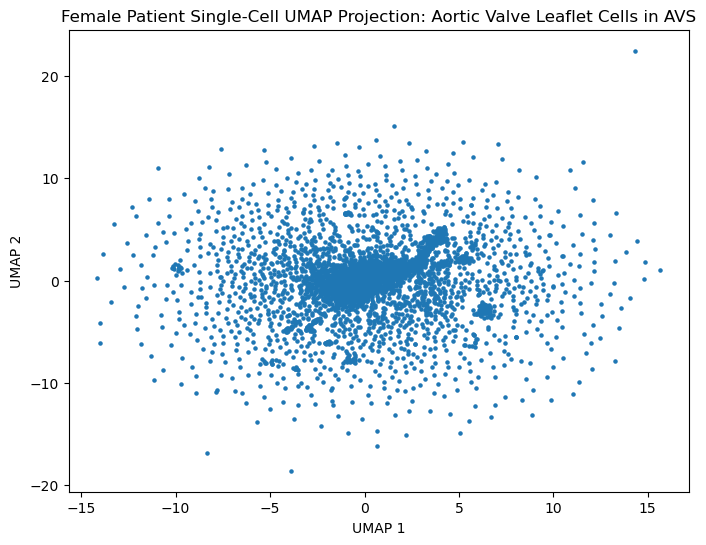

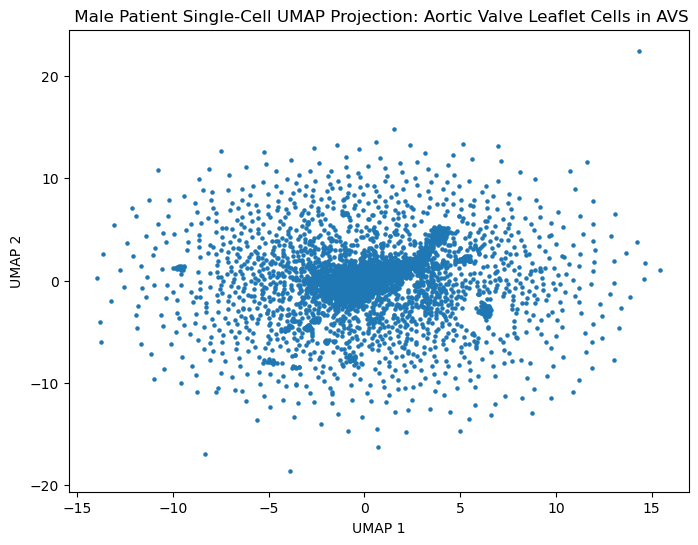

In [54]:
# Female sample
plot_umap(final_fem_embedding, title="Female Patient Single-Cell UMAP Projection: Aortic Valve Leaflet Cells in AVS")

# Male sample
plot_umap(final_male_embedding, title=" Male Patient Single-Cell UMAP Projection: Aortic Valve Leaflet Cells in AVS")

### Plotting the Cross-Entropy Optimization

In [55]:
def plot_optimization(iterations, loss_values, title):
    ''' Plots the UMAP optimization progress by visualizing the cross-entropy loss over iterations.

    Parameters:
        iterations (list): a list of integers containing the iteration numbers
        loss_values (list): a list containing the cross-entropy loss values at each iteration.
        title (str): title of the plot.

    Returns:
        None: displays the plot with loss values on the y-axis and iteration numbers on the x-axis.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, loss_values, marker='o', linestyle='-', color='tab:blue')
    plt.title(title, fontsize=14)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cross-Entropy Loss', fontsize=12)
    plt.show()

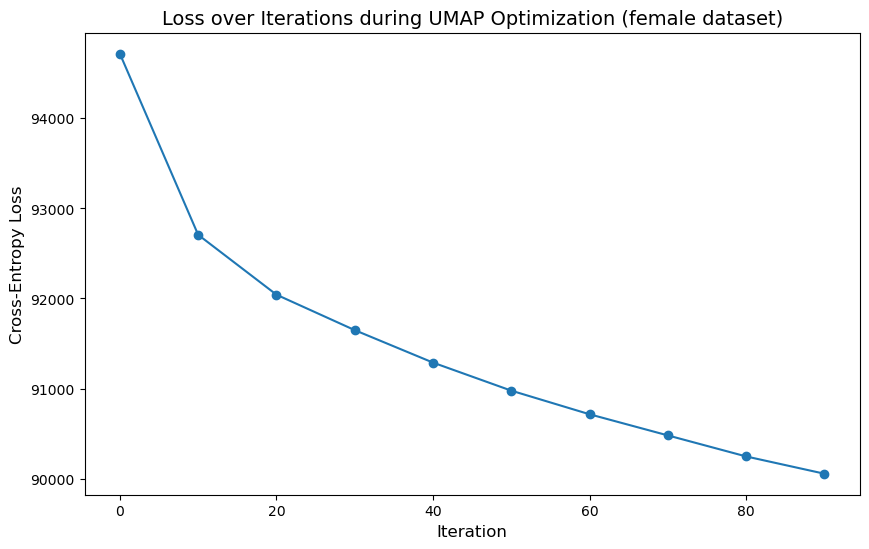

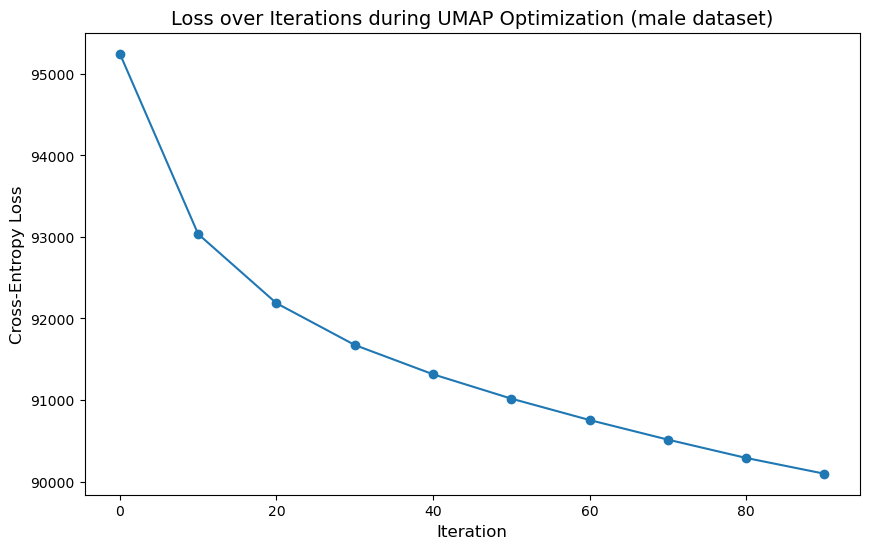

In [56]:
iterations = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
fem_loss_values = [
    94717.808394, 92707.100954, 92042.217898, 91648.584677,
    91288.015226, 90976.559372, 90714.265300, 90479.552085,
    90246.052480, 90054.146767
]
male_loss_values = [
    95247.281294, 93035.649956, 92187.536731, 91675.211230,
    91315.740198, 91017.201041, 90754.578002, 90514.253475,
    90289.576375, 90096.138191
]

plot_optimization(iterations, fem_loss_values, "Loss over Iterations during UMAP Optimization (female dataset)")
plot_optimization(iterations, male_loss_values, "Loss over Iterations during UMAP Optimization (male dataset)")

### Extra Visualization with Clustering Algorithms
Normally, I wouldn't really go straight to clustering without better optimizing the UMAP projections, but the embeddings here are enough to see some clusters. Due to the nature of KMeans (it doesn't handle non-spheroid clusters that well), DBSCAN is the I chose to quickly view some clusters.

In [86]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

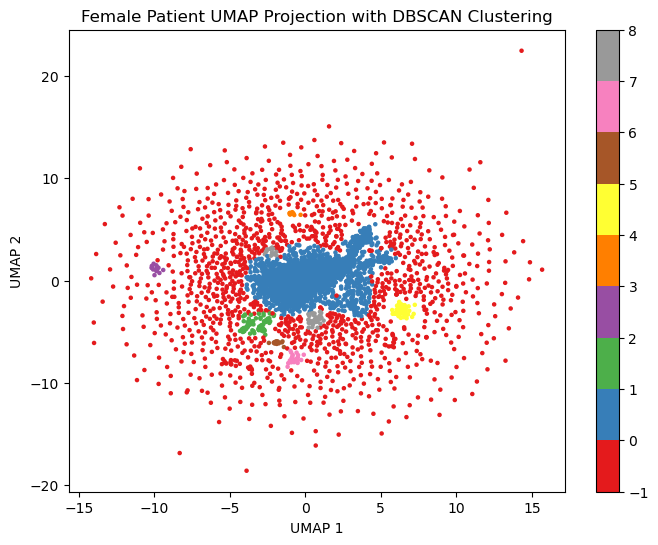

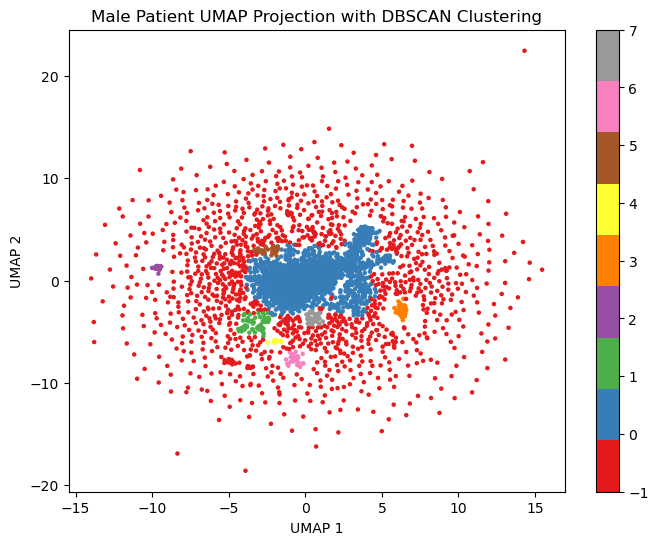

In [84]:
fem_dbscan = DBSCAN(eps=0.5, min_samples=12)
male_dbscan = DBSCAN(eps=0.5, min_samples=12)
fem_dbscan_labels = fem_dbscan.fit_predict(final_fem_embedding)
male_dbscan_labels = male_dbscan.fit_predict(final_male_embedding)

plot_umap(final_fem_embedding, labels=fem_dbscan_labels, title="Female Patient UMAP Projection with DBSCAN Clustering", cmap='Set1')

plot_umap(final_male_embedding, labels=male_dbscan_labels, title="Male Patient UMAP Projection with DBSCAN Clustering", cmap='Set1')

### Checking silhouette scores

The silhouette scores are moderately good, indicating that the clustering is relatively well-defined, but there is still a lot of room for refinement. This is somewhat expected, as the UMAP projection was not fully optimized due to the runtime constraints described earlier. Nevertheless, the scores demonstrate that the UMAP implementation has effectively reduced the 36,000+ features (genes) down to just 2 UMAP dimensions, preserving enough structure to identify meaningful clusters.

In [88]:
# Filtering out noise points
fem_mask = fem_dbscan_labels != -1
male_mask = male_dbscan_labels != -1
fem_filtered_embedding = final_fem_embedding[fem_mask]
male_filtered_embedding = final_male_embedding[male_mask]
fem_filtered_labels = fem_dbscan_labels[fem_mask]
male_filtered_labels = male_dbscan_labels[male_mask]

fem_silhouette = silhouette_score(fem_filtered_embedding, fem_filtered_labels)
male_silhouette = silhouette_score(male_filtered_embedding, male_filtered_labels)
print(f"Female Patient Silhouette Score With DBSCAN: {fem_silhouette:.3f}")
print(f"Male Patient Silhouette Score With DBSCAN: {male_silhouette:.3f}")

Female Patient Silhouette Score With DBSCAN: 0.442
Male Patient Silhouette Score With DBSCAN: 0.459


## Script Run Time

In [ ]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')